⏱️ Time at dy: 686362.0 sec
📏 dy: 250.02 mm
💪 Vy: 13670.53 kN
🔁 θy: 0.003363 rad
📈 My (from 3201): 33947.0 kN·m


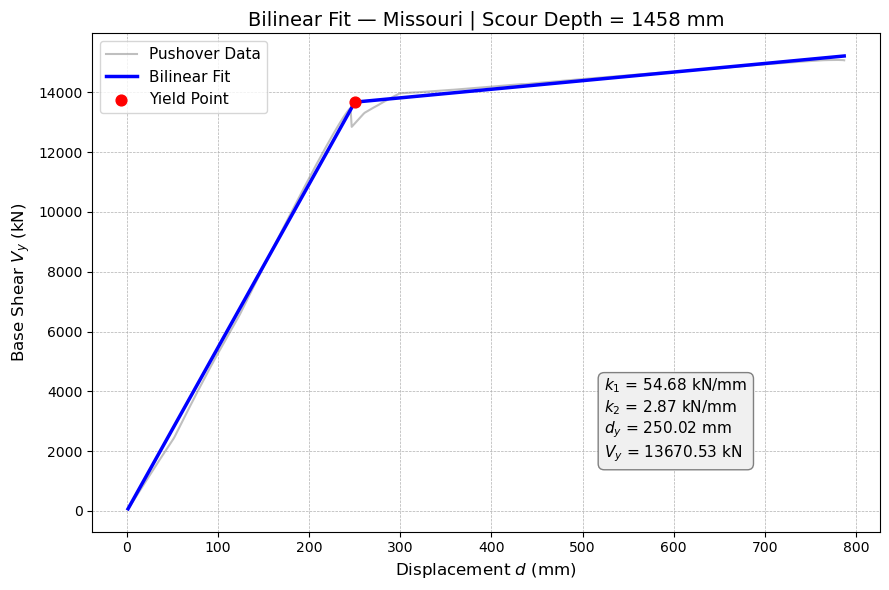

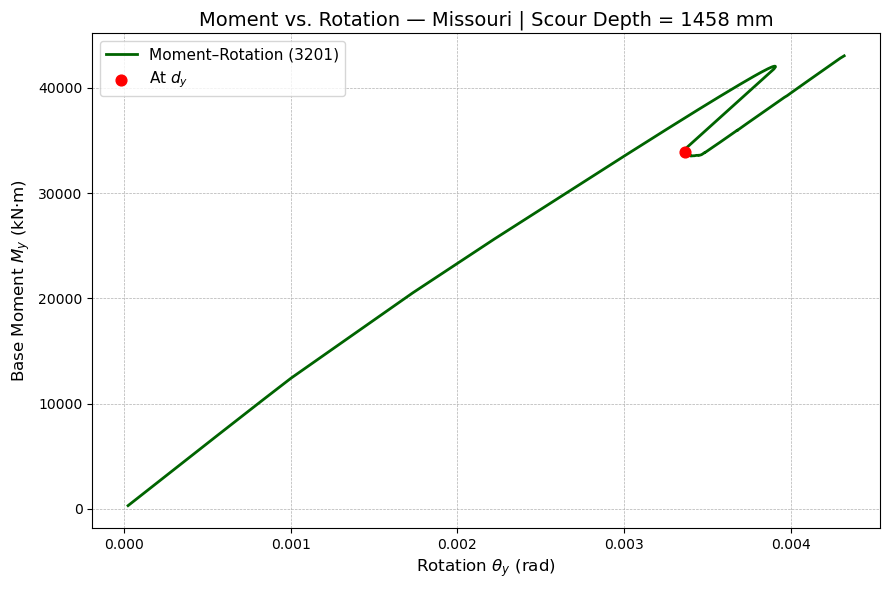

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ── Bilinear Fit Logic ──────────────────────────────────────────
def profile_fit(d, f, dy_grid):
    best_J = np.inf
    best_params = (None, None, None)
    for dy in dy_grid:
        I1 = d < dy
        I2 = ~I1
        if np.sum(I1) == 0 or np.sum(I2) == 0:
            continue
        num1 = np.sum(d[I1] * f[I1])
        den1 = np.sum(d[I1]**2)
        k1 = max(0, num1 / den1)
        num2 = np.sum((d[I2] - dy) * (f[I2] - k1 * dy))
        den2 = np.sum((d[I2] - dy)**2)
        k2 = num2 / den2
        fhat = np.where(d < dy, k1 * d, k2 * d + (k1 - k2) * dy)
        J = np.sum((f - fhat)**2)
        if J < best_J:
            best_J = J
            best_params = (k1, k2, dy)
    return best_params

def fit_bilinear_profile(d, f, num_grid=200):
    dy_min, dy_max = d.min(), d.max()
    dy_grid = np.linspace(dy_min + 1e-6, dy_max - 1e-6, num_grid)
    k1, k2, dy = profile_fit(d, f, dy_grid)
    Vy = k1 * dy
    return k1, k2, dy, Vy

# ── File Paths ─────────────────────────────────────────────────
folder = "RecorderData/Missouri/scour_7602.2"
disp_file = os.path.join(folder, "Displacement.5201.out")
col_disp_file = os.path.join(folder, "ColDisplacement.3201.out")
frc_file_3201 = os.path.join(folder, "ColLocForce.3201.out")
element_ids = [3101, 3201, 3301]
cols_forces = [
    "time", "P_i", "V2_i", "V3_i", "T_i", "M2_i", "M3_i",
    "P_j", "V2_j", "V3_j", "T_j", "M2_j", "M3_j"
]

# ── Load Displacement and Rotation ─────────────────────────────
df_disp = pd.read_csv(disp_file, sep=r"\s+", header=None)
df_disp.columns = ["time", "ux", "uy", "uz", "rx", "ry", "rz"]
disp_y = df_disp["uy"].abs()

df_col = pd.read_csv(col_disp_file, sep=r"\s+", header=None)
theta_y = df_col.iloc[:, 10].abs()

# ── Load Base Shear from All Elements ──────────────────────────
base_shear = None
for eleID in element_ids:
    frc_file = os.path.join(folder, f"ColLocForce.{eleID}.out")
    df_frc = pd.read_csv(frc_file, sep=r"\s+", header=None, names=cols_forces)
    shear = df_frc["V2_j"]
    base_shear = shear if base_shear is None else base_shear + shear

# ── Load Base Moment from Element 3201 ─────────────────────────
df_frc_3201 = pd.read_csv(frc_file_3201, sep=r"\s+", header=None, names=cols_forces)
moment = df_frc_3201["M3_j"].abs()

# ── Align Data Lengths ─────────────────────────────────────────
min_len = min(len(disp_y), len(base_shear), len(moment), len(theta_y))
d = disp_y[:min_len].values                # Displacement (mm)
f = base_shear[:min_len].abs().values / 1000.0  # Shear (kN)
m = moment[:min_len].values / 1e6               # Moment (kN·m)
t = theta_y[:min_len].values                    # Rotation (rad)

# ── Bilinear Fit ───────────────────────────────────────────────
k1_hat, k2_hat, dy_hat, Vy_hat = fit_bilinear_profile(d, f)

# ── Yield Info ────────────────────────────────────────────────
i_yield = np.argmin(np.abs(d - dy_hat))
time_yield = df_disp["time"].iloc[i_yield]
theta_y_yield = t[i_yield]
My_yield = m[i_yield]

print(f"⏱️ Time at dy: {time_yield:.1f} sec")
print(f"📏 dy: {dy_hat:.2f} mm")
print(f"💪 Vy: {Vy_hat:.2f} kN")
print(f"🔁 θy: {theta_y_yield:.6f} rad")
print(f"📈 My (from 3201): {My_yield:.1f} kN·m")

# ── Plot 1: Base Shear vs. Displacement ───────────────────────
output_path = Path("RecorderData/results/Figures")
output_path.mkdir(parents=True, exist_ok=True)

d_range = np.linspace(d.min(), d.max(), 500)
f_model = np.where(d_range < dy_hat, k1_hat * d_range, k2_hat * d_range + (k1_hat - k2_hat) * dy_hat)

plt.figure(figsize=(9, 6))
plt.plot(d, f, label="Pushover Data", color="gray", alpha=0.5, linewidth=1.5)
plt.plot(d_range, f_model, label="Bilinear Fit", color="blue", linewidth=2.5)
plt.scatter([dy_hat], [Vy_hat], color="red", zorder=10, label="Yield Point", s=60)

param_text = (
    f"$k_1$ = {k1_hat:.2f} kN/mm\n"
    f"$k_2$ = {k2_hat:.2f} kN/mm\n"
    f"$d_y$ = {dy_hat:.2f} mm\n"
    f"$V_y$ = {Vy_hat:.2f} kN"
)
plt.gca().text(0.65, 0.15, param_text, transform=plt.gca().transAxes,
               fontsize=11, bbox=dict(boxstyle="round,pad=0.4", facecolor="#f0f0f0", edgecolor="gray"))

plt.title("Bilinear Fit — Missouri | Scour Depth = 1458 mm", fontsize=14)
plt.xlabel("Displacement $d$ (mm)", fontsize=12)
plt.ylabel("Base Shear $V_y$ (kN)", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig(output_path / "Figure18.pdf")
plt.savefig(output_path / "Bilinear_Shear_Displacement.png", dpi=300)
plt.show()

# ── Plot 2: Moment vs. Rotation ────────────────────────────────
plt.figure(figsize=(9, 6))
plt.plot(t, m, label="Moment–Rotation (3201)", color="darkgreen", linewidth=2)
plt.scatter([theta_y_yield], [My_yield], color="red", zorder=10, s=60, label="At $d_y$")
plt.xlabel("Rotation $\\theta_y$ (rad)", fontsize=12)
plt.ylabel("Base Moment $M_y$ (kN·m)", fontsize=12)
plt.title("Moment vs. Rotation — Missouri | Scour Depth = 1458 mm", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig(output_path / "Figure19.pdf")
plt.savefig(output_path / "Moment_Rotation_Bilinear.png", dpi=300)
plt.show()


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── Bilinear Fit Logic ───────────────────────────────────────────────────

def profile_fit(d, f, dy_grid):
    records = []
    best_J = np.inf
    best_params = (None, None, None)
    for dy in dy_grid:
        I1 = d < dy
        I2 = ~I1
        if np.sum(I1) == 0 or np.sum(I2) == 0:
            continue
        d_I1 = d[I1]
        f_I1 = f[I1]
        num1 = np.sum(d_I1 * f_I1)
        den1 = np.sum(d_I1**2)
        k1 = max(0, num1 / den1)
        num2 = np.sum((d[I2] - dy) * (f[I2] - k1 * dy))
        den2 = np.sum((d[I2] - dy)**2)
        k2 = num2 / den2
        fhat = np.where(d < dy, k1 * d, k2 * d + (k1 - k2) * dy)
        J = np.sum((f - fhat)**2)
        records.append((dy, list(d_I1), list(f_I1), k1, k2, J))
        if J < best_J:
            best_J = J
            best_params = (k1, k2, dy)
    return best_params, records

def fit_bilinear_profile(d, f, num_grid=200):
    dy_min, dy_max = d.min(), d.max()
    dy_grid = np.linspace(dy_min + 1e-6, dy_max - 1e-6, num_grid)
    (k1, k2, dy), records = profile_fit(d, f, dy_grid)
    Vy = k1 * dy
    return k1, k2, dy, Vy, records

# ── Example Inputs (Replace with Your File Paths) ─────────────────────────────
folder = "RecorderData/Missouri/scour_7602.2"
disp_file = os.path.join(folder, "Displacement.5201.out")
col_disp_file = os.path.join(folder, "ColDisplacement.3201.out")
frc_file_3201 = os.path.join(folder, "ColLocForce.3201.out")
element_ids = [3101, 3201, 3301]
cols_forces = ["time", "P_i", "V2_i", "V3_i", "T_i", "M2_i", "M3_i", "P_j", "V2_j", "V3_j", "T_j", "M2_j", "M3_j"]

# ── Load Displacement and Rotation ─────────────────────────────

df_disp = pd.read_csv(disp_file, sep=r"\s+", header=None)
df_disp.columns = ["time", "ux", "uy", "uz", "rx", "ry", "rz"]
disp_y = df_disp["uy"].abs()

df_col = pd.read_csv(col_disp_file, sep=r"\s+", header=None)
theta_y = df_col.iloc[:, 10].abs()

# ── Load Base Shear from All Elements ─────────────────────────────
base_shear = None
for eleID in element_ids:
    frc_file = os.path.join(folder, f"ColLocForce.{eleID}.out")
    df_frc = pd.read_csv(frc_file, sep=r"\s+", header=None, names=cols_forces)
    shear = df_frc["V2_j"]
    base_shear = shear if base_shear is None else base_shear + shear

# ── Load Base Moment Only from Element 3201 ─────────────────────────

df_frc_3201 = pd.read_csv(frc_file_3201, sep=r"\s+", header=None, names=cols_forces)
moment = df_frc_3201["M3_j"].abs()

# ── Align Data Lengths ─────────────────────────────
min_len = min(len(disp_y), len(base_shear), len(moment), len(theta_y))
d = disp_y[:min_len].values  # mm
f = base_shear[:min_len].abs().values / 1000.0  # kN
m = moment[:min_len].values / 1e6  # kN·m
t = theta_y[:min_len].values  # rad

# ── Fit Bilinear Model for Shear ─────────────────────────
k1_hat, k2_hat, dy_hat, Vy_hat, records = fit_bilinear_profile(d, f)

# ── Export to Excel ─────────────────────────────

df_export = pd.DataFrame(records, columns=["dy", "d_i", "f_i", "k1", "k2", "J"])
excel_path = os.path.join(folder, "Bilinear_Fit_Results.xlsx")
df_export.to_excel(excel_path, index=False)

# Export full original displacement-force data
from openpyxl import load_workbook
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    df_full = pd.DataFrame({"d": d, "f": f})
    df_full.to_excel(writer, sheet_name="Original_Data", index=False)

print(f"✅ Bilinear fit results and original data exported to {excel_path}")

✅ Bilinear fit results and original data exported to RecorderData/Missouri/scour_7602.2\Bilinear_Fit_Results.xlsx


In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# === Bilinear Fit Logic ===
def profile_fit(d, f, dy_grid):
    best_J = np.inf
    best_params = (None, None, None)
    for dy in dy_grid:
        I1 = d < dy
        I2 = ~I1
        if np.sum(I1) == 0 or np.sum(I2) == 0:
            continue
        k1 = max(0, np.sum(d[I1] * f[I1]) / np.sum(d[I1]**2))
        k2 = np.sum((d[I2] - dy) * (f[I2] - k1 * dy)) / np.sum((d[I2] - dy)**2)
        fhat = np.where(d < dy, k1 * d, k2 * d + (k1 - k2) * dy)
        J = np.sum((f - fhat)**2)
        if J < best_J:
            best_J = J
            best_params = (k1, k2, dy)
    return best_params

def fit_bilinear_profile(d, f, num_grid=200):
    dy_min, dy_max = d.min(), d.max()
    dy_grid = np.linspace(dy_min + 1e-6, dy_max - 1e-6, num_grid)
    k1, k2, dy = profile_fit(d, f, dy_grid)
    Vy = k1 * dy
    return k1, k2, dy, Vy

# === Setup Paths ===
base_dir = Path("RecorderData")
plot_dir = Path("Plots")
base_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

scenarios = ["Missouri", "Colorado", "Extreme"]
element_ids = [3101, 3201, 3301]
cols_forces = [
    "time", "P_i", "V2_i", "V3_i", "T_i", "M2_i", "M3_i",
    "P_j", "V2_j", "V3_j", "T_j", "M2_j", "M3_j"
]

results_dict = {}

for scenario in scenarios:
    data = []
    scenario_dir = base_dir / scenario
    plot_scenario_dir = plot_dir / scenario
    plot_scenario_dir.mkdir(parents=True, exist_ok=True)

    for folder in sorted(scenario_dir.glob("scour_*")):
        try:
            scour_depth = float(folder.name.split("_")[1])
            disp_file = folder / "Displacement.5201.out"
            col_disp_file = folder / "ColDisplacement.3201.out"
            frc_file_3201 = folder / "ColLocForce.3201.out"

            if not (disp_file.exists() and col_disp_file.exists() and frc_file_3201.exists()):
                continue

            # === Load Displacement and Rotation ===
            df_disp = pd.read_csv(disp_file, sep=r"\s+", header=None)
            df_disp.columns = ["time", "ux", "uy", "uz", "rx", "ry", "rz"]
            disp_y = df_disp["uy"].abs()

            df_col = pd.read_csv(col_disp_file, sep=r"\s+", header=None)
            theta_y = df_col.iloc[:, 10].abs()

            # === Load Base Shear from All Columns ===
            base_shear = None
            for eleID in element_ids:
                frc_file = folder / f"ColLocForce.{eleID}.out"
                df_frc = pd.read_csv(frc_file, sep=r"\s+", header=None, names=cols_forces)
                shear = df_frc["V2_j"]
                base_shear = shear if base_shear is None else base_shear + shear

            # === Load Moment from Element 3201 ===
            df_frc_3201 = pd.read_csv(frc_file_3201, sep=r"\s+", header=None, names=cols_forces)
            moment = df_frc_3201["M3_j"].abs()

            # === Trim and Compute ===
            min_len = min(len(disp_y), len(base_shear), len(moment), len(theta_y))
            d = disp_y[:min_len].values
            f = base_shear[:min_len].abs().values / 1000.0
            m = moment[:min_len].values / 1e6
            t = theta_y[:min_len].values

            # === Fit Bilinear ===
            k1, k2, dy, Vy = fit_bilinear_profile(d, f)
            i_yield = np.argmin(np.abs(d - dy))
            My = m[i_yield]
            Thy = t[i_yield]

            data.append({
                "Scour_Depth_mm": scour_depth,
                "dy_mm": round(dy, 3),
                "Vy_kN": round(Vy, 2),
                "My_kNm": round(My, 2),
                "Thy_rad": round(Thy, 5),
                "k1_kN_per_mm": round(k1, 2),
                "k2_kN_per_mm": round(k2, 2)
            })

            # === Plot and Save ===
            d_range = np.linspace(d.min(), d.max(), 500)
            f_model = np.where(d_range < dy, k1 * d_range, k2 * d_range + (k1 - k2) * dy)

            fig, ax = plt.subplots(figsize=(8, 5))
            ax.plot(d, f, color="gray", alpha=0.5)
            ax.plot(d_range, f_model, color="blue")
            ax.scatter([dy], [Vy], color="red", zorder=10)

            # Add Combined Text Box (info + legend)
            props = dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8)
            textstr = '\n'.join((
                r'Pushover: gray line',
                r'Bilinear Fit: blue line',
                r'Yield: red dot',
                '',
                rf'$k_1 = {k1:.2f}\ \mathrm{{kN/mm}}$',
                rf'$k_2 = {k2:.2f}\ \mathrm{{kN/mm}}$',
                rf'$d_y = {dy:.2f}\ \mathrm{{mm}}$',
                rf'$V_y = {Vy:.2f}\ \mathrm{{kN}}$'
            ))
            ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
                    fontsize=9, verticalalignment='bottom', horizontalalignment='right', bbox=props)

            ax.set_title(f"{scenario} | Scour = {scour_depth} mm")
            ax.set_xlabel("Displacement $d$ (mm)")
            ax.set_ylabel("Base Shear $V_y$ (kN)")
            ax.grid(True, linestyle="--", alpha=0.5)
            fig.tight_layout()
            fig.savefig(plot_scenario_dir / f"scour_{scour_depth}.png")
            plt.close(fig)

        except Exception as e:
            print(f"⚠️ Skipped {folder.name}: {e}")
            continue

    if data:
        df = pd.DataFrame(data).sort_values("Scour_Depth_mm")
        results_dict[scenario] = df

# === Save to Excel if any data ===
if results_dict:
    excel_path = base_dir / "Yield_Results_by_Scenario.xlsx"
    with pd.ExcelWriter(excel_path) as writer:
        for scenario, df in results_dict.items():
            df.to_excel(writer, sheet_name=scenario, index=False)
    print(f"✅ Saved results to {excel_path}")
else:
    print("⚠️ No results to save.")


✅ Saved results to RecorderData\Yield_Results_by_Scenario.xlsx


In [7]:
# surrogate_model_training.py
"""
Train bootstrap‑ensembled SVR and GBR surrogates for bridge capacity prediction,
returning credal‑set (min–max) bounds.

Usage (terminal):
    python surrogate_model_training.py  # trains on RecorderData/Yield_Results_by_Scenario.xlsx

Functions can be imported elsewhere to integrate with larger pipelines.
"""

from pathlib import Path
from typing import Tuple, List

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.utils import resample


# ──────────────────────────────────────────────────────────────────────────────
# Data loading
# ──────────────────────────────────────────────────────────────────────────────

def load_data(excel_path: Path, *, scenario: str | None = None,
              features: List[str] | None = None,
              target: str = "Vy_kN") -> Tuple[np.ndarray, np.ndarray]:
    """Read the Excel written by your yield‑extraction script.

    Parameters
    ----------
    excel_path : Path to Yield_Results_by_Scenario.xlsx
    scenario   : If given, filter rows to this scenario (e.g., "Missouri")
    features   : Feature columns to use; default = ["Scour_Depth_mm"]
    target     : Response column (e.g., "Vy_kN", "dy_mm", etc.)
    """
    book = pd.read_excel(excel_path, sheet_name=None)
    df = pd.concat(book.values(), ignore_index=True)
    if scenario:
        df = df[df["Scenario"] == scenario]
    if features is None:
        features = ["Scour_Depth_mm"]
    X = df[features].values
    y = df[target].values
    return X, y


# ──────────────────────────────────────────────────────────────────────────────
# Model definitions + hyper‑search spaces
# ──────────────────────────────────────────────────────────────────────────────

def make_svr_pipeline() -> Tuple[Pipeline, dict]:
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("svr", SVR())
    ])
    param = {
        "svr__kernel": ["rbf", "poly"],
        "svr__C": np.logspace(-1, 3, 20),
        "svr__gamma": np.logspace(-3, 1, 20),
        "svr__epsilon": np.linspace(0.01, 1.0, 15),
    }
    return pipe, param


def make_gbr() -> Tuple[GradientBoostingRegressor, dict]:
    model = GradientBoostingRegressor(random_state=0)
    param = {
        "n_estimators": [100, 200, 400],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.6, 0.8, 1.0],
    }
    return model, param


# ──────────────────────────────────────────────────────────────────────────────
# Bootstrap‑ensemble (credal set) helpers
# ──────────────────────────────────────────────────────────────────────────────

def fit_ensemble(X: np.ndarray, y: np.ndarray, model_name: str, *, B: int = 20,
                 n_iter: int = 25, cv: int = 5, rng: int = 42):
    """Return a list of B tuned models trained on bootstrap resamples."""
    rng = np.random.RandomState(rng)
    makers = {"SVR": make_svr_pipeline, "GBR": make_gbr}
    make_model = makers[model_name]
    models = []
    for b in range(B):
        X_bs, y_bs = resample(X, y, replace=True, random_state=rng.randint(1e6))
        base, space = make_model()
        search = RandomizedSearchCV(base, space, n_iter=n_iter, cv=cv,
                                    scoring="r2", n_jobs=-1,
                                    random_state=rng.randint(1e6))
        search.fit(X_bs, y_bs)
        models.append(search.best_estimator_)
    return models


def ensemble_predict(models, X: np.ndarray):
    """Return mean, lower, and upper predictions for credal bounds."""
    preds = np.column_stack([m.predict(X) for m in models])
    return preds.mean(axis=1), preds.min(axis=1), preds.max(axis=1)


# ──────────────────────────────────────────────────────────────────────────────
# Main routine (run as script)
# ──────────────────────────────────────────────────────────────────────────────

def main():
    excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
    X, y = load_data(excel_path, target="Vy_kN")
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0)

    for name in ("SVR", "GBR"):
        ensemble = fit_ensemble(X_tr, y_tr, name)
        y_hat, y_lo, y_hi = ensemble_predict(ensemble, X_te)
        print(f"{name} test R²  : {r2_score(y_te, y_hat):.3f}")
        print(f"{name} avg CI ±: {np.mean(y_hi - y_lo):.1f}\n")


if __name__ == "__main__":
    main()


SVR test R²  : 0.167
SVR avg CI ±: 114.1

GBR test R²  : 0.172
GBR avg CI ±: 288.6



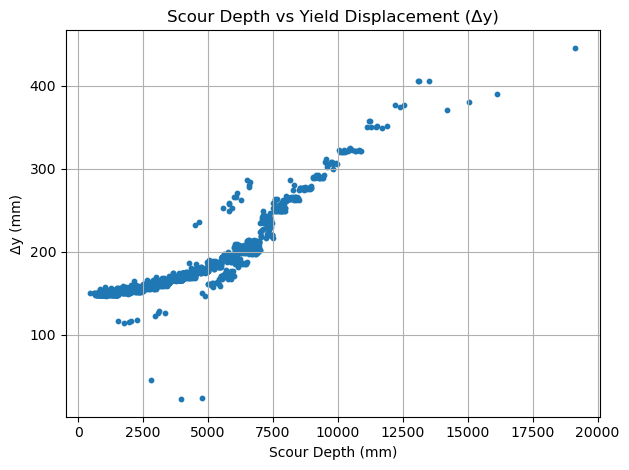

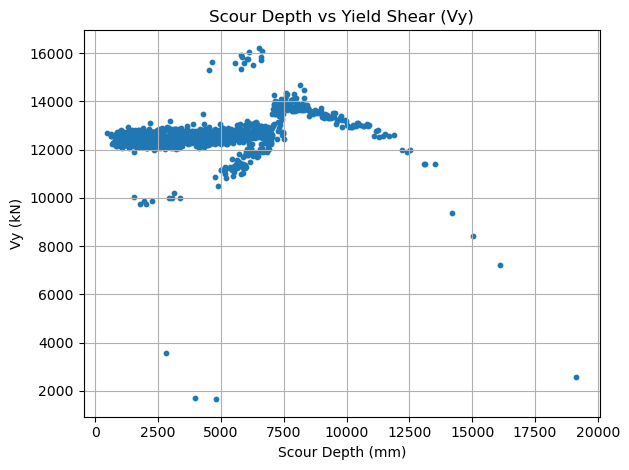

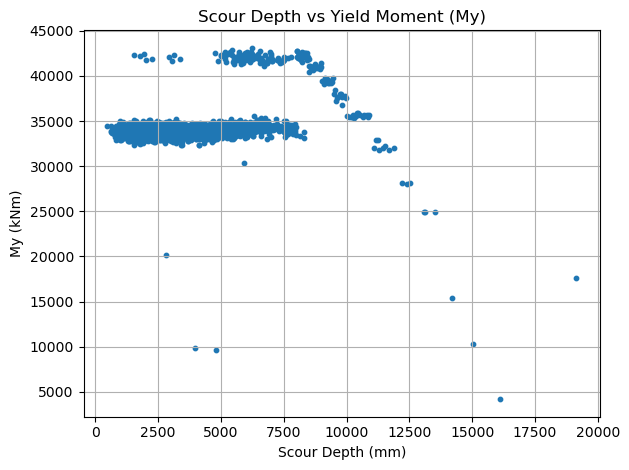

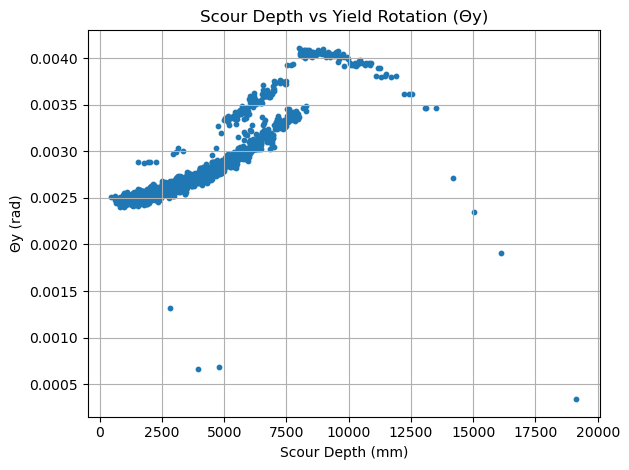

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Paths ===
input_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
output_dir = Path("RecorderData/HazardPlots")
output_dir.mkdir(parents=True, exist_ok=True)

# === Load data ===
xls = pd.ExcelFile(input_path)
df = pd.concat([xls.parse(sheet) for sheet in xls.sheet_names], ignore_index=True)

# === Plot functions ===
def make_scatter(x, y, x_label, y_label, title, filename):
    fig, ax = plt.subplots()
    ax.scatter(df[x], df[y], s=10)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True)
    fig.tight_layout()
    fig.savefig(output_dir / filename, dpi=300)
    plt.show()

# === Generate plots ===
make_scatter("Scour_Depth_mm", "dy_mm", "Scour Depth (mm)", "Δy (mm)",
             "Scour Depth vs Yield Displacement (Δy)", "Scour_vs_Dy.png")

make_scatter("Scour_Depth_mm", "Vy_kN", "Scour Depth (mm)", "Vy (kN)",
             "Scour Depth vs Yield Shear (Vy)", "Scour_vs_Vy.png")

make_scatter("Scour_Depth_mm", "My_kNm", "Scour Depth (mm)", "My (kNm)",
             "Scour Depth vs Yield Moment (My)", "Scour_vs_My.png")

make_scatter("Scour_Depth_mm", "Thy_rad", "Scour Depth (mm)", "Θy (rad)",
             "Scour Depth vs Yield Rotation (Θy)", "Scour_vs_Thy.png")
